In [1]:
!pip install redis
!pip install wordcloud
from os import chdir
chdir('../')
%matplotlib inline
from lib import *
suppress_warnings()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
conn, cur = conpg(location = 'postgres')
sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '36 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)
len(df)

32598

In [3]:
df = df[~df['hashtags'].str.contains('amp')]
df = df[~df['hashtags'].str.contains('job|hiring|sales|retail|clerical|jobs|careerarc')]
df = df[~df['hashtags'].str.contains('dallas|plano|irving|richardson|garland|allen|odessa|midland|sanfrancisco|losangeles|irvine|garland')]
len(df)

24396

In [4]:
#df[~df['location'].str.contains('.ca|california')][~df['location'].str.contains('.tx|texas')]
ca_df = df[df['location'].str.contains('.ca|california')]
tx_df = df[df['location'].str.contains('.tx|texas')]

In [5]:
hastages_series = df['hashtags']
len(hastages_series)

24396

In [6]:
from PIL import Image
def word_cloud(state = None): 
    state=state.lower()
    #state_mask = np.array(Image.open("./doc/{}.jpg".format(state)))
    #state = state.lower()
    state_df = df[df['location'].str.contains('.{}'.format(state))]
    words = state_df['hashtags'][(state_df['hashtags'].isnull() == False) & (state_df['hashtags'] != 'None')]
    stopwords = set(STOPWORDS)
    #stopwords.add("amp")
    wc = WordCloud(width=1600, height=1600, background_color='black', \
                   relative_scaling=1, stopwords=stopwords, max_words=300, colormap='winter').generate(' '.join(i for i in words))
    #wc.to_file("./doc/{}.jpg".format(state))
    #, colormap='copper',mask=state_mask
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

In [7]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit_transform(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [8]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    
    return result

In [9]:
def new_trend_period(trend_group):        
    new_result = []
    count = 0
    for i in range(len(trend_group)-1):
        if (count > len(trend_group)-2):
            pass
        else:
            gap = ((trend_group[count+1][0]) - (trend_group[count][len(trend_group[count])-1]))
            if gap <.8*min((trend_group[count+1][0]), (trend_group[count][len(trend_group[count])-1])):
                new_period = trend_group[count]+trend_group[count+1]
                new_result.append(new_period)
                count +=2
            else:
                new_result.append(trend_group[count])
                count +=1
    return new_result

In [10]:
def get_arr(hashtag):
    time_delta, min_time, time_window, time_lag, time_gap, windows = get_time()
    hashtag = hashtag.lower()
    arr = []
    start_time = min_time
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap    
    return arr

In [11]:
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    time_delta, min_time, time_window, time_lag, time_gap, windows = get_time()
    arr = get_arr(hashtag)
    timeline = []
    w = np.array(range(windows))
    for i in w:
        timeline.append((min_time) + time_gap * i) 
    arr = np.array(arr)  
    grad = np.gradient(arr)
    time_df = pd.DataFrame({'arr':arr,'grad':grad},index=timeline)
    sma_arr = pd.rolling_mean(arr, window=4)
    sma_grad = np.gradient(sma_arr)
    
    arr_df = pd.DataFrame(arr)
    ewm_arr = arr_df.ewm(alpha=0.3,min_periods=4,adjust=False, ignore_na=True).mean()
    ewm_grad = np.gradient(np.array(ewm_arr).reshape(1,-1)[0])
    
    trend_sma = np.argwhere(sma_grad>0.001).reshape(1,-1)[0]
    trend_group_sma = group_consecutives(trend_sma)      
    trend_group_sma1 = new_trend_period(trend_group_sma)
    trend_group_sma2 = [i for i in trend_group_sma1 if (len(i) > 7)]
    
    trend_ewm = np.argwhere(ewm_grad>0.0001).reshape(1,-1)[0]
    trend_group_ewm = group_consecutives(trend_ewm)      
    trend_group_ewm1 = new_trend_period(trend_group_ewm)
    trend_group_ewm2 = [i for i in trend_group_ewm1 if (len(i) > 7)]
    #rolstd_arr = pd.rolling_std(arr, window=4)
    spike = []
    spike.append([[i[0],i[len(i)-1]] for i in trend_group_ewm2])
    spike = np.array(spike)
    spk1 = [i[0] for i in spike[0]]
    spk2 = [i[1] for i in spike[0]] 
    
    forecast, stderr, con_int = get_arima(hashtag)
    forecast = np.append(arr,forecast)
    stderr = np.append(arr,stderr)
    upper = np.append(arr,con_int[:,0])
    lower = np.append(arr,con_int[:,1])
    plt.figure(figsize=(20,10))
    plt.axvline(w[-1], color = 'lightgray',linestyle='dashed')
    plt.plot(forecast, c = 'gray',linewidth = 3, label = 'forecast')
    #plt.plot(stderr, c = 'lightcoral',linestyle='dashed', label = 'Standard Error')
    plt.plot(upper, c = 'gray',linestyle='dashed', label = 'Confidence Interval')
    plt.plot(lower, c = 'gray',linestyle='dashed')
    plt.plot(arr, label='Hashtag Frequency',c = 'dimgray',linewidth = 3)
    plt.plot(ewm_arr, label='Exponential Weighted Moving Avg(EMA)',c = 'salmon',linewidth = 2)
    plt.plot(sma_arr, label='Simple Moving Avg(SMA)',c = 'dodgerblue')
    #plt.plot(rolstd_arr, label='Rolling STDs',c = 'gold')
    plt.plot(sma_grad, label='Gradient over SMA',c = 'mediumblue')
    plt.plot(ewm_grad, label='Gradient over EMA',c = 'red')
    for j,k in zip(spk1,spk2):
        spike1 = (min_time + time_gap * j).replace(tzinfo=from_zone).astimezone(to_zone).strftime(time_format)                   
        plt.axvline(j, color = 'salmon',linestyle='dashed', label = 'Trending: {}'.format(spike1))
        plt.axvspan(j, k, alpha=0.2, color='lightcoral')
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12) 
    plt.show()
    return  

In [12]:
def get_time():
    time_delta = (max(df['created_datetime'])) - min(df['created_datetime'])
    min_time = min(df['created_datetime'])
    time_window = time_delta.components.days*24 + time_delta.components.hours
    time_lag = timedelta(hours = .5)
    time_gap = timedelta(hours = .5)
    windows = int(round(time_delta/time_gap,0))
    return time_delta, min_time, time_window, time_lag, time_gap, windows

In [13]:
from statsmodels.tsa.arima_model import ARIMA
def fit_arima(arr):
    arima_df = pd.DataFrame({'perf':arr})   
    series = arima_df.dropna()
    model = ARIMA(np.array(series.values), order=(4,1,0))
    model_fit = model.fit()
    return model_fit

In [14]:
## ARIMA
## AR: Autoregression
## I: Intergrated
## MA: Moving Average
## order: p,q,d
## p: # of lag observations included in the model
## d: # of times in the raw observations are differenced
## q: the size of the moving average window
from statsmodels.tsa.arima_model import ARIMA
def get_arima(hashtag):
    arr = get_arr(hashtag)
    model_fit = fit_arima(arr)
    forecast_ = model_fit.forecast(steps=10)
    forecast = forecast_[0]+arr[-1]
    stderr = forecast_[1]+arr[-1]
    con_int = forecast_[2]+arr[-1]
    return forecast, stderr, con_int

In [15]:
from statsmodels.tsa.arima_model import ARIMA
def arima_residuals_plt(hashtag): 
    arr = get_arr(hashtag)
    model_fit = fit_arima(arr)
    print(model_fit.summary())
    # plot residual errors
    residuals =pd. DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())

In [16]:
hashtag_freq_df = pd.DataFrame({'hashtag': count_vectorizer.get_feature_names(), 'occurrences':np.asarray(hashtags_countvec.sum(axis=0)).ravel().tolist()})
hashtag_freq_df['frequency'] = hashtag_freq_df['occurrences']/np.sum(hashtag_freq_df['occurrences'])
hashtag_freq_df.sort_values(by = 'occurrences',ascending = False, inplace = True)

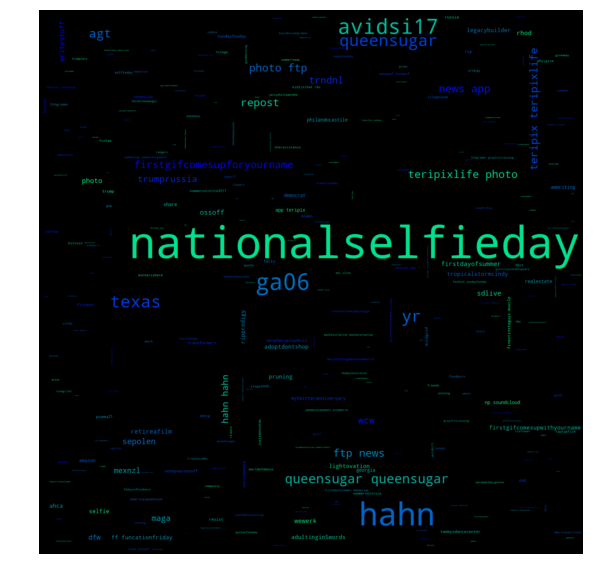

In [17]:
word_cloud('TX')

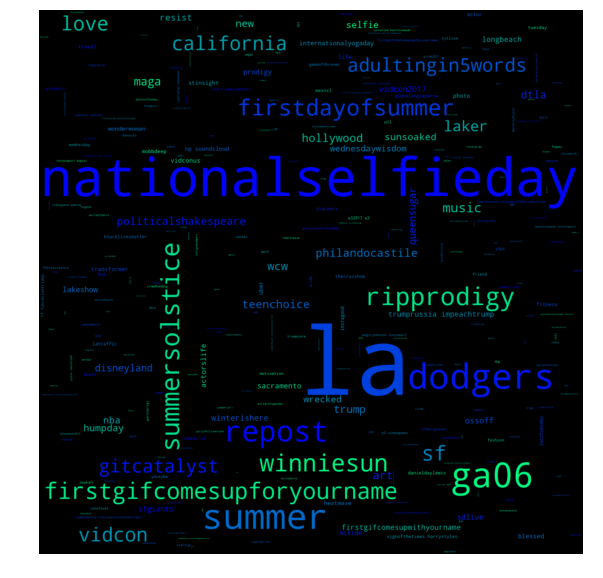

In [18]:
word_cloud('CA')

In [19]:
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
to_zone = 'US/Pacific'
time_delta, min_time, time_window, time_lag, time_gap, windows = get_time()
print('\tstart time: ',min_time.replace(tzinfo=from_zone).astimezone(to_zone).strftime(time_format),'\n',\
      '\tend time:  ', max(df['created_datetime']).replace(tzinfo=from_zone).astimezone(to_zone).strftime(time_format),'\n',\
      '\ttotal hours: ',time_window,'\n',\
      '\ttime lag: ', time_lag,'\n',\
      '\ttime gap: ', time_gap,'\n',\
      '\ttime windows: ', windows)

	start time:  2017-Jun-20 Tue 11 AM 
 	end time:   2017-Jun-21 Wed 04 PM 
 	total hours:  28 
 	time lag:  0:30:00 
 	time gap:  0:30:00 
 	time windows:  58


In [20]:
hashtag_freq_df.head(10)

,hashtag,occurrences,frequency
12940,nationalselfieday,365,0.007690
7315,ga06,283,0.005962
13528,nowplaying,278,0.005857
4570,cubevenue,265,0.005583
10551,la,243,0.005119
18164,summer,189,0.003982
5351,dodgers,186,0.003919
18783,teenchoice,176,0.003708
15735,repost,166,0.003497
18226,summersolstice,165,0.003476


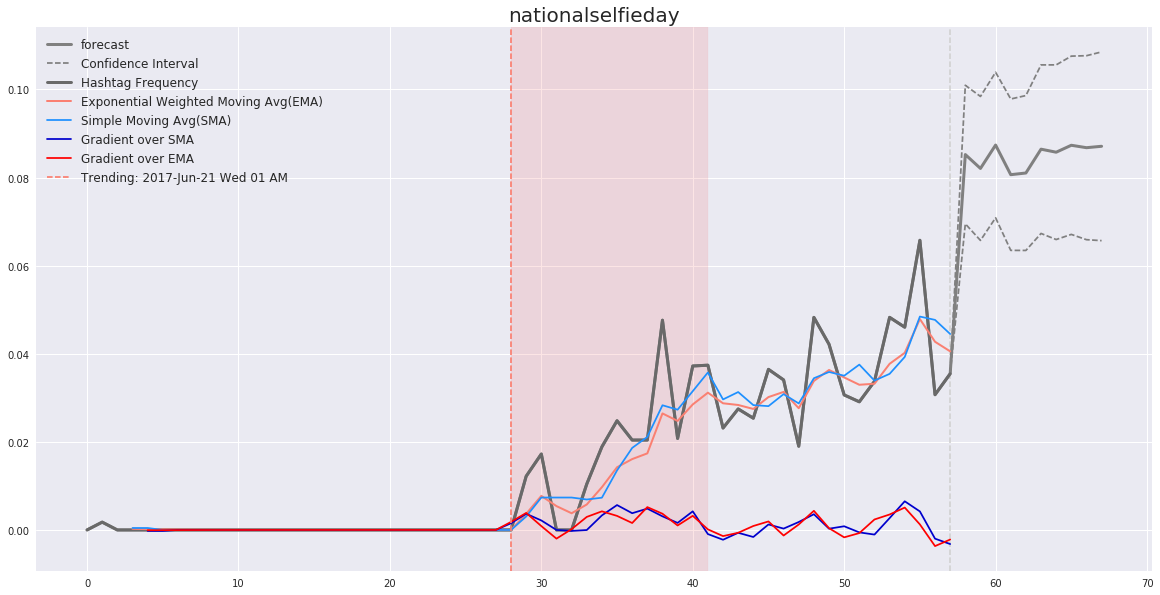

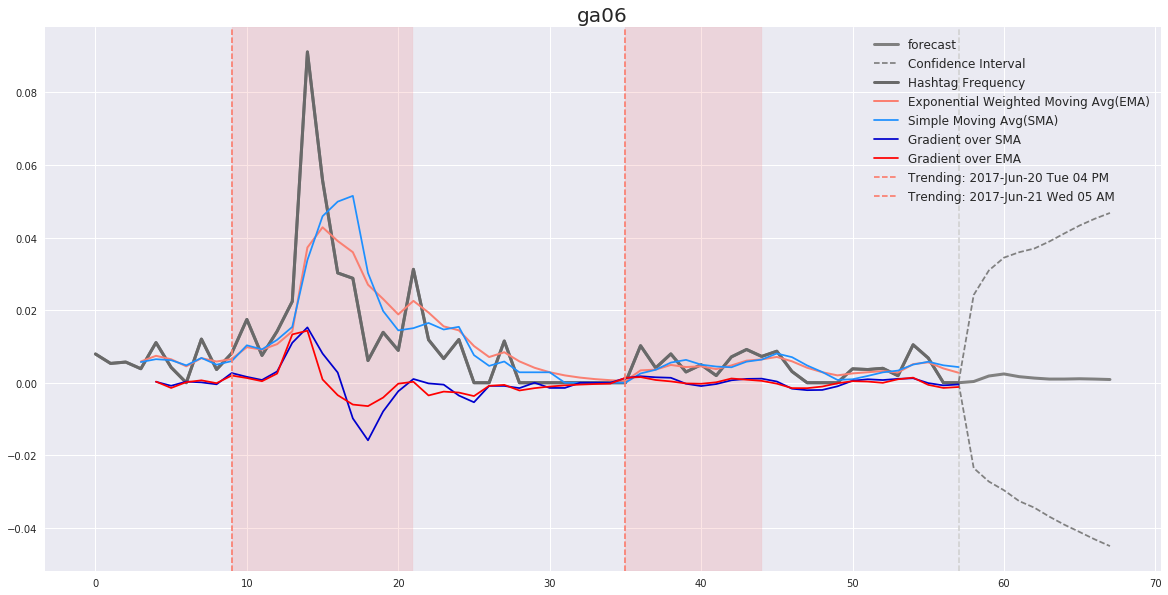

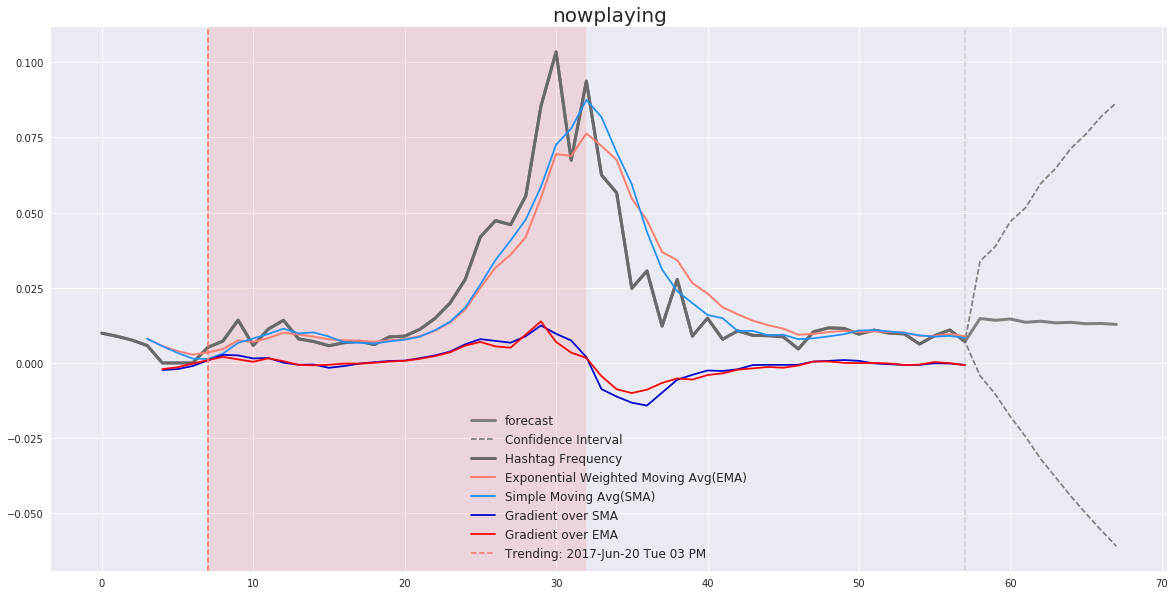

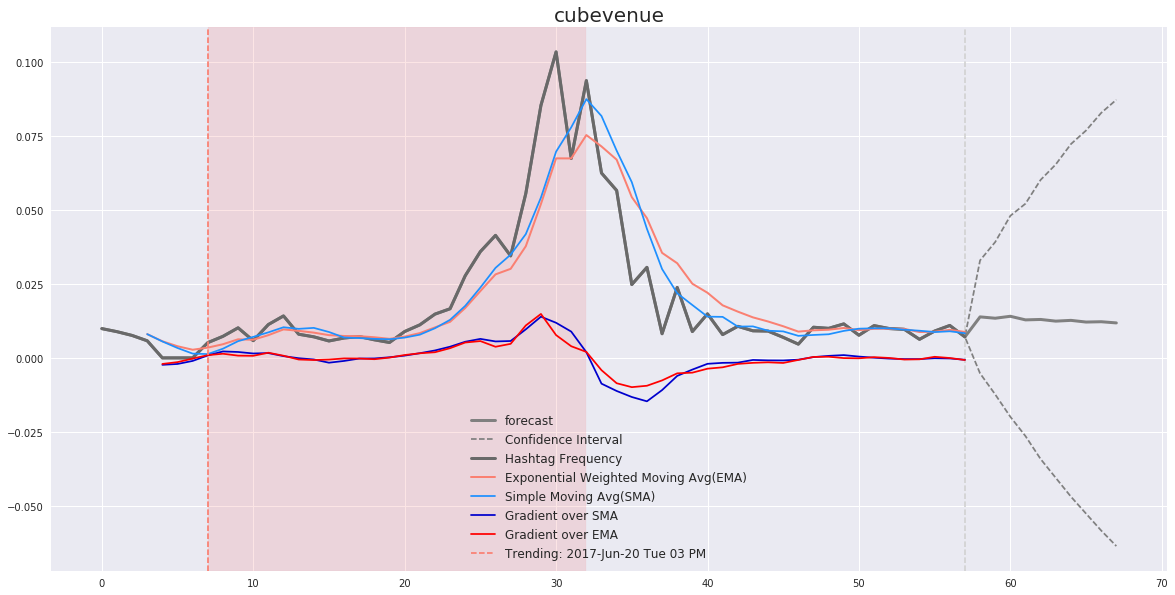

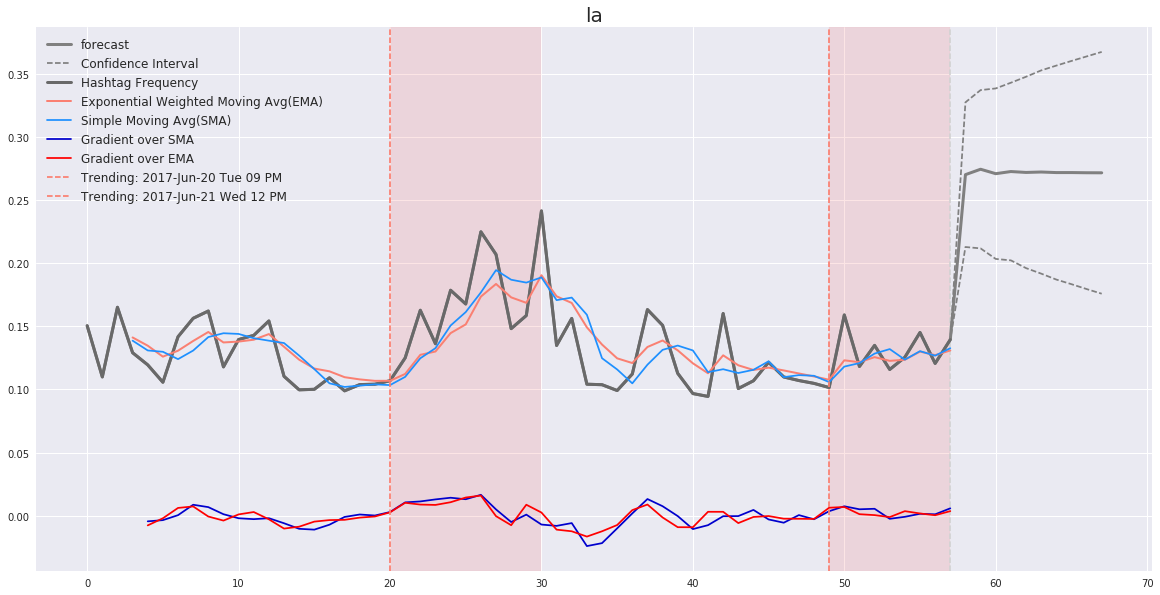

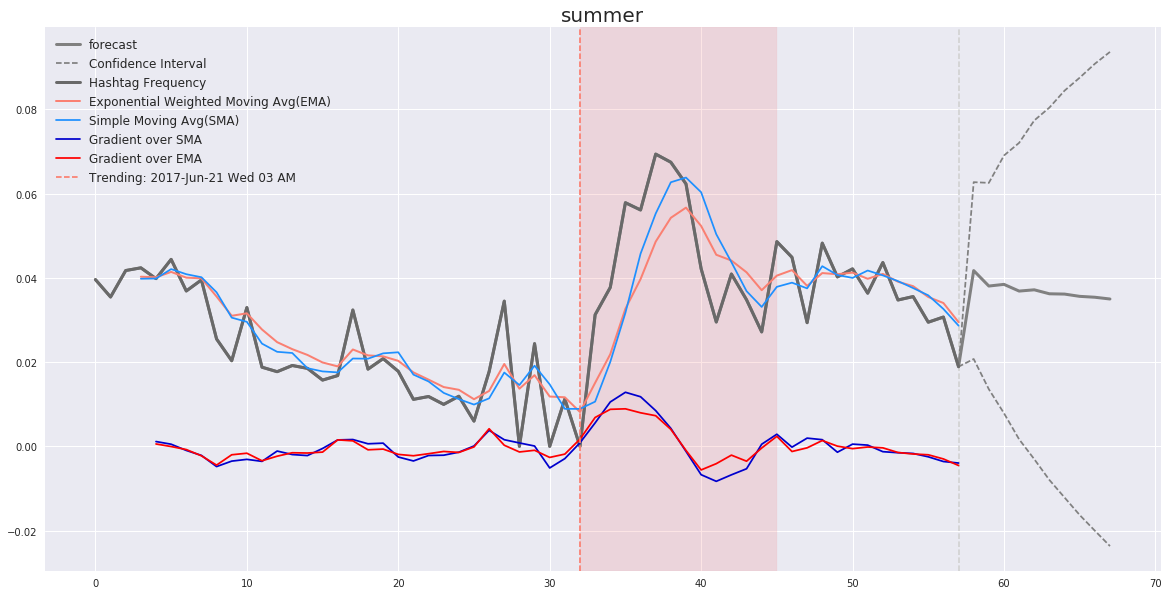

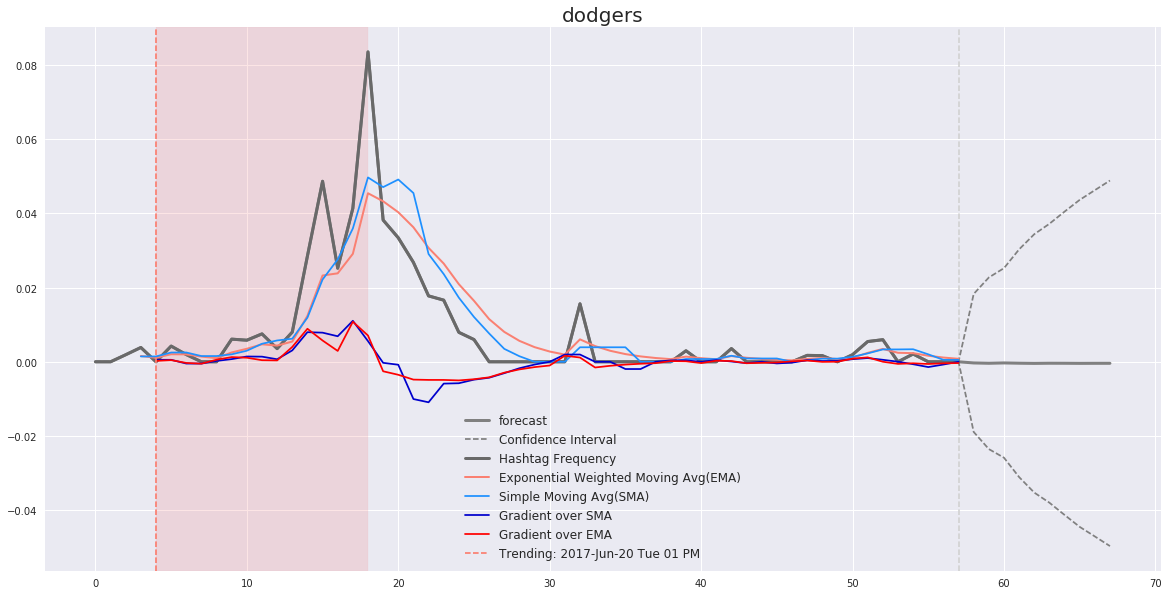

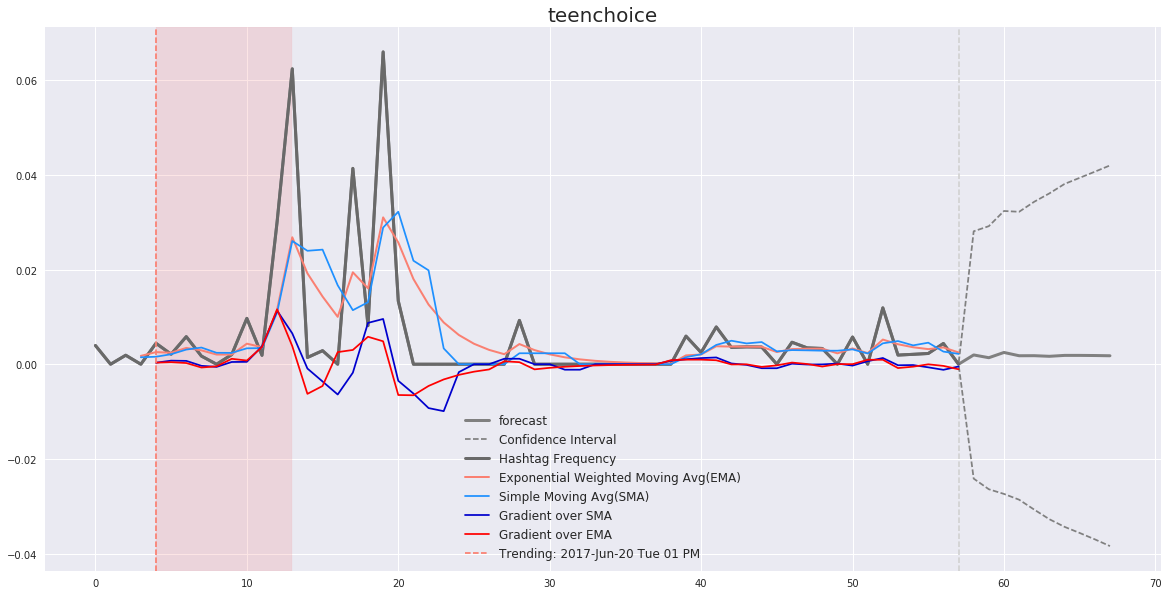

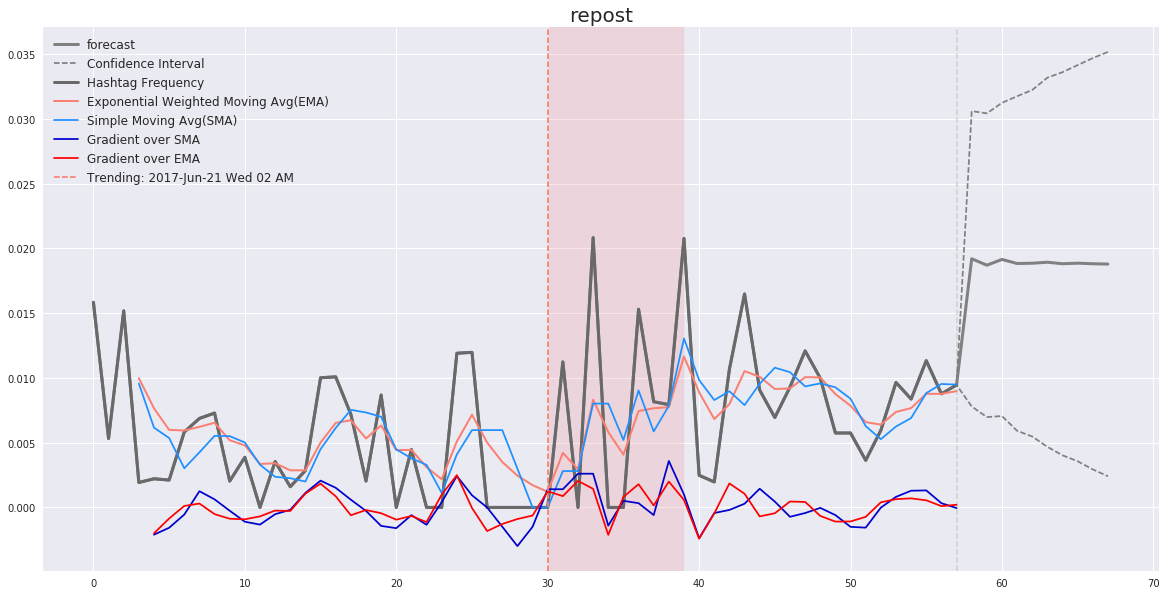

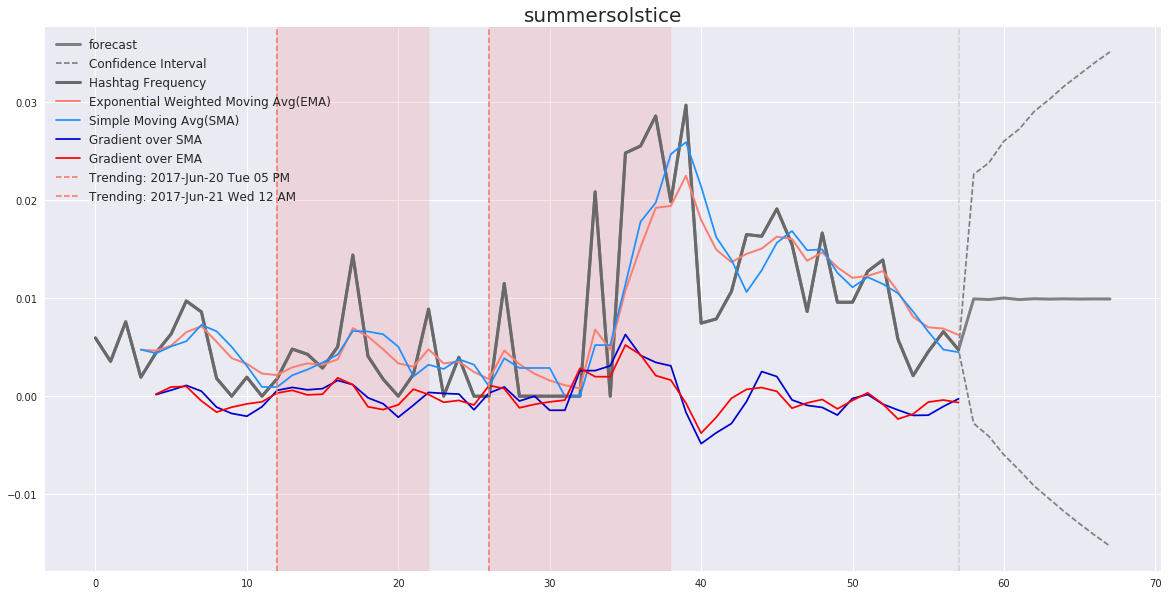

[None, None, None, None, None, None, None, None, None, None]

In [21]:
[hashtag_trend(i) for i in (hashtag_freq_df['hashtag'].head(10))]

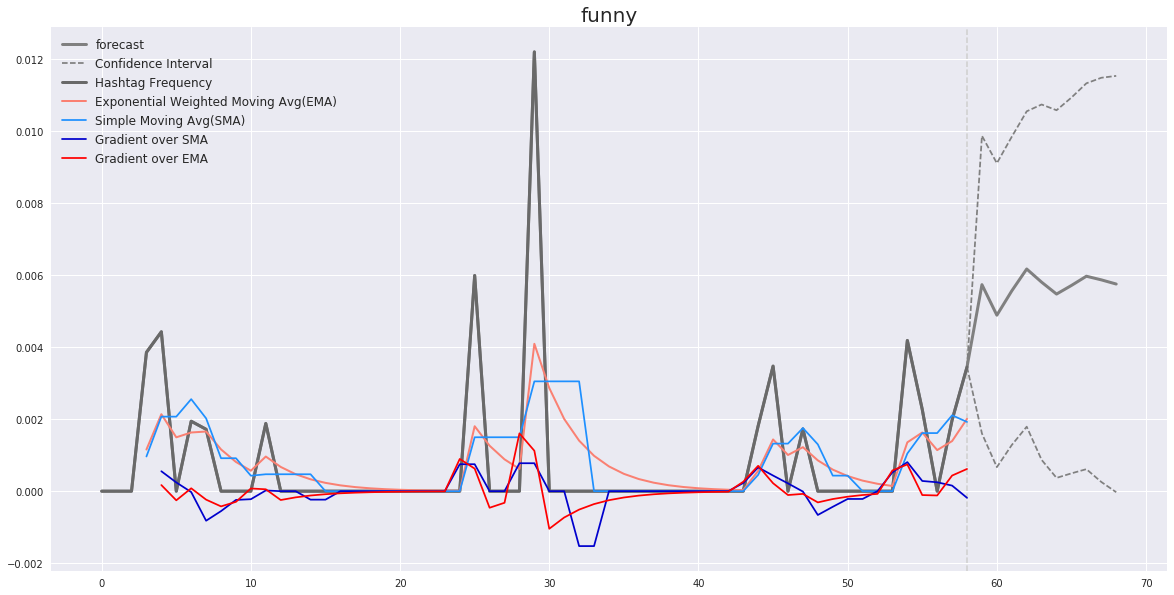

In [27]:
hashtag_trend('funny')

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   57
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 120.262
Method:                       css-mle   S.D. of innovations              0.029
Date:                Wed, 21 Jun 2017   AIC                           -228.525
Time:                        23:55:11   BIC                           -216.267
Sample:                             1   HQIC                          -223.761
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.058      0.954      -0.004       0.003
ar.L1.D.y     -0.5561      0.133     -4.197      0.000      -0.816      -0.296
ar.L2.D.y     -0.3155      0.146     -2.155      0.0

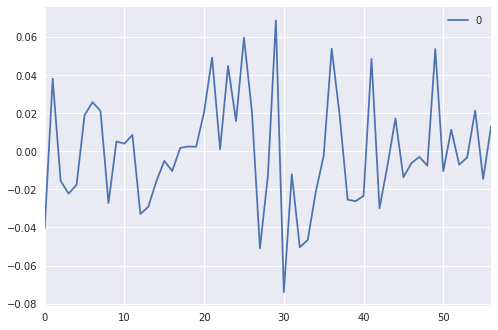

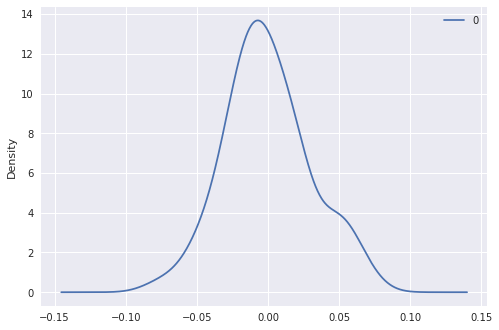

               0
count  57.000000
mean   -0.000294
std     0.029652
min    -0.073997
25%    -0.017593
50%    -0.003180
75%     0.018980
max     0.068752


In [23]:
arima_residuals_plt('la')

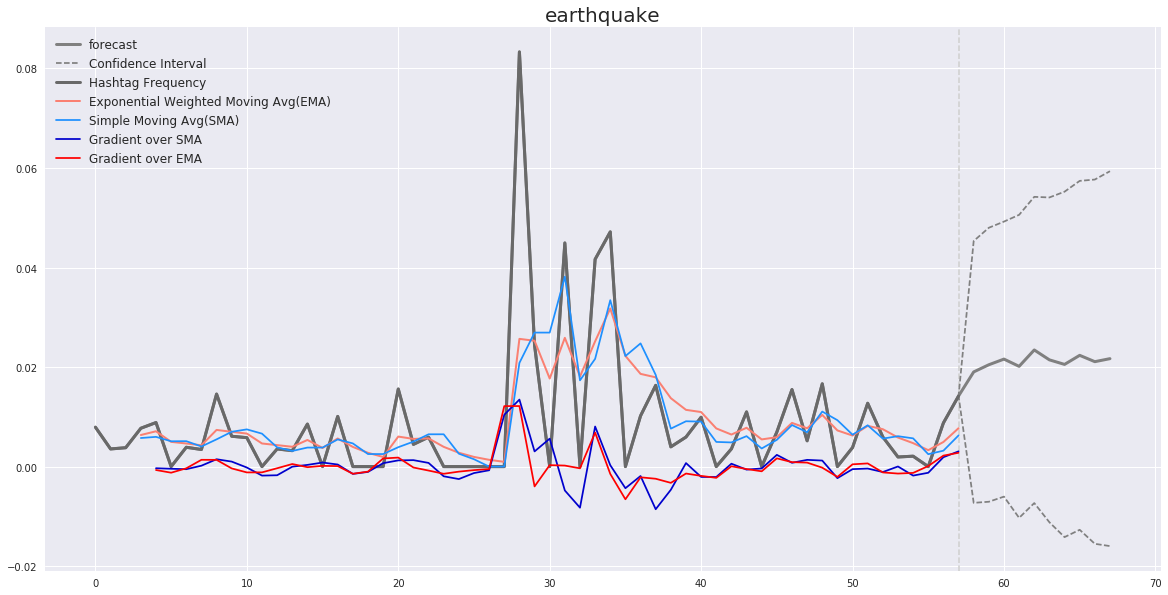

In [24]:
hashtag_trend('earthquake')

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   57
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 164.120
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 21 Jun 2017   AIC                           -316.239
Time:                        23:55:16   BIC                           -303.981
Sample:                             1   HQIC                          -311.475
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.123e-05      0.001      0.035      0.972      -0.001       0.001
ar.L1.D.y     -0.6920      0.123     -5.641      0.000      -0.932      -0.452
ar.L2.D.y     -0.6953      0.150     -4.635      0.0

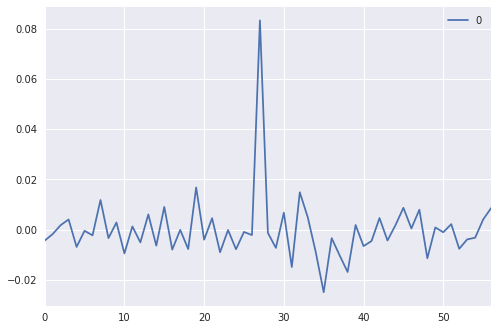

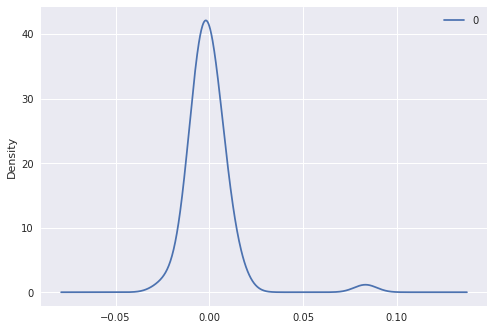

               0
count  57.000000
mean   -0.000050
std     0.013552
min    -0.024944
25%    -0.006587
50%    -0.001340
75%     0.003991
max     0.083270


In [25]:
arima_residuals_plt('earthquake')

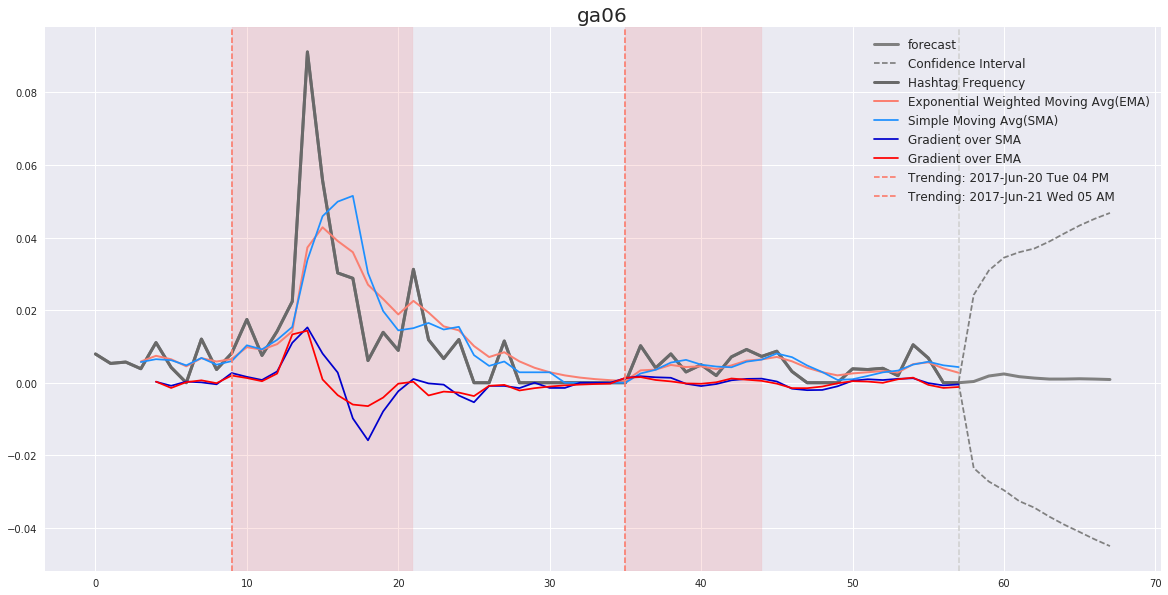

In [26]:
hashtag_trend('ga06')

as the rolling std increase the tweet freq increases 
if the rolling std decrease, the tweet freq decrease